In [1]:
import joblib
import gzip
import pandas
import pickle
import seaborn
import tqdm

from lib.models.generic_v0.model import map_params

In [2]:
import sys

util_dir = "./sprint-0-explicit-mdps/"
sys.path.append(util_dir)

import util

In [3]:
mdps = pandas.read_pickle("5-generated-mdps/fixed.pkl.gz")
mdps

,problem,model,force_consider_own,merge_isomorphic,truncate_common_chain,collect_garbage,reward_common_chain,protocol,dag_size_limit,size,time_spent,rss,mdp
0,ref-fc16,fc16sapirshtein,True,True,True,True,True,bitcoin,4,18,0.001028,0.173290,2469d26c
1,ref-aft20,aft20barzur,True,True,True,True,True,bitcoin,4,15,0.000389,0.182377,23549bf0
2,v1,generic-v1,False,False,True,True,True,bitcoin,4,267,0.081922,0.182194,10bf8d39
3,v1,generic-v1,False,False,True,True,True,ethereum_3,4,327,0.121194,0.203922,2f121a4b
4,v1,generic-v1,False,False,True,True,True,byzantium_3,4,327,0.129278,0.209507,3d4eddd8
5,v1,generic-v1,False,False,True,True,True,ghostdag_3,4,352,0.156716,0.210522,10147b0d
6,v1,generic-v1,False,False,True,True,True,parallel_3,4,206,0.070239,0.221989,51f91e0c
7,v1+fc,generic-v1,True,False,True,True,True,bitcoin,4,58,0.020006,0.210754,7f71e743
8,v1+fc,generic-v1,True,False,True,True,True,ethereum_3,4,78,0.033353,0.214771,33e2ffb6
9,v1+fc,generic-v1,True,False,True,True,True,byzantium_3,4,78,0.036254,0.214039,62aaf326


In [4]:
networks = []
# for alpha in range(35, 41, 5):
for alpha in range(5, 51, 5):
    for gamma in [0.33, 0.66]:
        # for gamma in [0, 0.5, 1]:
        networks.append(dict(alpha=alpha / 100, gamma=gamma))
# pandas.DataFrame(networks)

In [5]:
horizon = 100
stop_delta = (
    0.0001  # value iteration stops when no value estimate changes more than this value
)

In [6]:
def optimize(network, idx, row):
    with gzip.open(f"5-generated-mdps/mdp-{row.mdp}.pkl.gz", "rb") as f:
        emdp = pickle.load(f)
        emdp = map_params(emdp, **network)
        oae = util.optimize_and_evaluate(emdp, eps=stop_delta, horizon=horizon)
        return row.to_dict() | dict(horizon=horizon) | network | oae


def generate_jobs():
    for network in networks:
        for idx, row in mdps.iterrows():
            # if row['size'] > 1000:
            #    continue
            yield joblib.delayed(optimize)(network, idx, row)


jobs = list(generate_jobs())
generate_solutions = joblib.Parallel(return_as="generator_unordered", n_jobs=6)(jobs)
with_progress = tqdm.tqdm(generate_solutions, total=len(jobs))
df = pandas.DataFrame(with_progress)
df.to_pickle("5-value-iterations.pkl.gz")
df

  0%|                                                                                                                                                            | 0/480 [00:00<?, ?it/s]

  0%|▎                                                                                                                                                   | 1/480 [00:00<04:26,  1.80it/s]

  0%|▌                                                                                                                                                   | 2/480 [00:00<02:46,  2.87it/s]

  1%|▉                                                                                                                                                   | 3/480 [00:01<03:07,  2.55it/s]

  1%|█▏                                                                                                                                                  | 4/480 [00:01<02:40,  2.96it/s]

  1%|█▌                                                                                                                                                  | 5/480 [00:01<02:06,  3.74it/s]

  1%|██▏                                                                                                                                                 | 7/480 [00:01<01:31,  5.18it/s]

  2%|██▍                                                                                                                                                 | 8/480 [00:01<01:19,  5.92it/s]

  2%|███▎                                                                                                                                               | 11/480 [00:02<00:56,  8.37it/s]

  2%|███▋                                                                                                                                               | 12/480 [00:02<01:11,  6.55it/s]

  3%|███▉                                                                                                                                               | 13/480 [00:02<01:21,  5.71it/s]

  3%|████▎                                                                                                                                              | 14/480 [00:02<01:14,  6.26it/s]

  3%|████▌                                                                                                                                              | 15/480 [00:02<01:10,  6.55it/s]

  4%|██████▏                                                                                                                                            | 20/480 [00:03<00:33, 13.60it/s]

  5%|███████                                                                                                                                            | 23/480 [00:03<00:29, 15.30it/s]

  5%|███████▋                                                                                                                                           | 25/480 [00:03<00:47,  9.63it/s]

  6%|████████▎                                                                                                                                          | 27/480 [00:04<01:26,  5.25it/s]

  6%|█████████▍                                                                                                                                         | 31/480 [00:04<01:07,  6.63it/s]

  7%|██████████▍                                                                                                                                        | 34/480 [00:05<01:01,  7.29it/s]

  8%|███████████                                                                                                                                        | 36/480 [00:05<01:13,  6.05it/s]

  8%|███████████▎                                                                                                                                       | 37/480 [00:05<01:13,  6.06it/s]

  9%|████████████▌                                                                                                                                      | 41/480 [00:06<00:52,  8.37it/s]

  9%|█████████████▍                                                                                                                                     | 44/480 [00:06<00:43, 10.06it/s]

 10%|██████████████                                                                                                                                     | 46/480 [00:06<00:38, 11.37it/s]

 10%|██████████████▋                                                                                                                                    | 48/480 [00:06<00:51,  8.39it/s]

 10%|███████████████▎                                                                                                                                   | 50/480 [00:07<01:36,  4.47it/s]

 11%|███████████████▌                                                                                                                                   | 51/480 [00:08<01:31,  4.71it/s]

 11%|███████████████▉                                                                                                                                   | 52/480 [00:08<01:28,  4.83it/s]

 11%|████████████████▏                                                                                                                                  | 53/480 [00:08<01:25,  5.01it/s]

 11%|████████████████▌                                                                                                                                  | 54/480 [00:08<01:15,  5.65it/s]

 11%|████████████████▊                                                                                                                                  | 55/480 [00:08<01:10,  6.03it/s]

 12%|█████████████████▏                                                                                                                                 | 56/480 [00:08<01:17,  5.46it/s]

 12%|█████████████████▍                                                                                                                                 | 57/480 [00:09<01:16,  5.55it/s]

 12%|█████████████████▊                                                                                                                                 | 58/480 [00:09<01:17,  5.44it/s]

 12%|██████████████████                                                                                                                                 | 59/480 [00:09<01:35,  4.42it/s]

 12%|██████████████████▍                                                                                                                                | 60/480 [00:10<02:04,  3.39it/s]

 13%|██████████████████▋                                                                                                                                | 61/480 [00:10<01:57,  3.57it/s]

 14%|███████████████████▉                                                                                                                               | 65/480 [00:10<01:05,  6.31it/s]

 14%|████████████████████▊                                                                                                                              | 68/480 [00:10<00:45,  8.99it/s]

 15%|█████████████████████▍                                                                                                                             | 70/480 [00:10<00:45,  9.10it/s]

 15%|██████████████████████                                                                                                                             | 72/480 [00:11<00:57,  7.13it/s]

 15%|██████████████████████▎                                                                                                                            | 73/480 [00:12<01:35,  4.28it/s]

 15%|██████████████████████▋                                                                                                                            | 74/480 [00:12<01:51,  3.64it/s]

 16%|██████████████████████▉                                                                                                                            | 75/480 [00:12<01:44,  3.86it/s]

 16%|███████████████████████▎                                                                                                                           | 76/480 [00:12<01:32,  4.37it/s]

 16%|███████████████████████▉                                                                                                                           | 78/480 [00:13<01:08,  5.84it/s]

 16%|████████████████████████▏                                                                                                                          | 79/480 [00:13<01:15,  5.34it/s]

 17%|█████████████████████████                                                                                                                          | 82/480 [00:13<01:08,  5.78it/s]

 17%|█████████████████████████▍                                                                                                                         | 83/480 [00:14<01:29,  4.46it/s]

 18%|██████████████████████████                                                                                                                         | 85/480 [00:14<01:13,  5.36it/s]

 18%|██████████████████████████▋                                                                                                                        | 87/480 [00:14<01:07,  5.83it/s]

 19%|███████████████████████████▌                                                                                                                       | 90/480 [00:14<00:45,  8.66it/s]

 19%|████████████████████████████▏                                                                                                                      | 92/480 [00:15<00:43,  8.96it/s]

 20%|████████████████████████████▊                                                                                                                      | 94/480 [00:15<00:36, 10.63it/s]

 20%|█████████████████████████████▍                                                                                                                     | 96/480 [00:15<00:51,  7.44it/s]

 20%|██████████████████████████████                                                                                                                     | 98/480 [00:16<01:45,  3.61it/s]

 21%|██████████████████████████████▍                                                                                                                   | 100/480 [00:17<01:34,  4.04it/s]

 21%|██████████████████████████████▋                                                                                                                   | 101/480 [00:17<01:30,  4.17it/s]

 21%|███████████████████████████████▎                                                                                                                  | 103/480 [00:17<01:16,  4.95it/s]

 22%|███████████████████████████████▋                                                                                                                  | 104/480 [00:17<01:19,  4.72it/s]

 22%|███████████████████████████████▉                                                                                                                  | 105/480 [00:18<01:28,  4.24it/s]

 22%|████████████████████████████████▌                                                                                                                 | 107/480 [00:18<01:26,  4.30it/s]

 22%|████████████████████████████████▊                                                                                                                 | 108/480 [00:19<02:04,  2.99it/s]

 23%|█████████████████████████████████▍                                                                                                                | 110/480 [00:19<01:34,  3.92it/s]

 24%|██████████████████████████████████▎                                                                                                               | 113/480 [00:19<01:02,  5.85it/s]

 24%|██████████████████████████████████▉                                                                                                               | 115/480 [00:20<00:54,  6.66it/s]

 24%|███████████████████████████████████▌                                                                                                              | 117/480 [00:20<00:43,  8.30it/s]

 25%|████████████████████████████████████▏                                                                                                             | 119/480 [00:20<00:35, 10.04it/s]

 25%|████████████████████████████████████▊                                                                                                             | 121/480 [00:21<01:32,  3.89it/s]

 26%|█████████████████████████████████████▍                                                                                                            | 123/480 [00:22<01:40,  3.54it/s]

 26%|█████████████████████████████████████▋                                                                                                            | 124/480 [00:22<01:31,  3.88it/s]

 26%|██████████████████████████████████████▎                                                                                                           | 126/480 [00:22<01:13,  4.79it/s]

 26%|██████████████████████████████████████▋                                                                                                           | 127/480 [00:22<01:13,  4.77it/s]

 27%|███████████████████████████████████████▏                                                                                                          | 129/480 [00:23<01:00,  5.78it/s]

 27%|███████████████████████████████████████▌                                                                                                          | 130/480 [00:23<01:12,  4.82it/s]

 27%|███████████████████████████████████████▊                                                                                                          | 131/480 [00:23<01:32,  3.77it/s]

 28%|████████████████████████████████████████▏                                                                                                         | 132/480 [00:24<01:32,  3.74it/s]

 28%|████████████████████████████████████████▍                                                                                                         | 133/480 [00:24<01:35,  3.62it/s]

 28%|█████████████████████████████████████████                                                                                                         | 135/480 [00:24<01:03,  5.40it/s]

 29%|█████████████████████████████████████████▋                                                                                                        | 137/480 [00:24<00:56,  6.06it/s]

 29%|██████████████████████████████████████████▎                                                                                                       | 139/480 [00:24<00:42,  7.99it/s]

 29%|██████████████████████████████████████████▉                                                                                                       | 141/480 [00:25<00:40,  8.28it/s]

 30%|███████████████████████████████████████████▍                                                                                                      | 143/480 [00:25<00:38,  8.86it/s]

 30%|████████████████████████████████████████████                                                                                                      | 145/480 [00:26<01:34,  3.56it/s]

 30%|████████████████████████████████████████████▍                                                                                                     | 146/480 [00:27<01:54,  2.92it/s]

 31%|█████████████████████████████████████████████                                                                                                     | 148/480 [00:27<01:27,  3.80it/s]

 31%|█████████████████████████████████████████████▎                                                                                                    | 149/480 [00:27<01:19,  4.15it/s]

 31%|█████████████████████████████████████████████▋                                                                                                    | 150/480 [00:27<01:11,  4.61it/s]

 31%|█████████████████████████████████████████████▉                                                                                                    | 151/480 [00:27<01:08,  4.79it/s]

 32%|██████████████████████████████████████████████▌                                                                                                   | 153/480 [00:28<00:53,  6.13it/s]

 32%|██████████████████████████████████████████████▊                                                                                                   | 154/480 [00:28<01:13,  4.46it/s]

 32%|███████████████████████████████████████████████▏                                                                                                  | 155/480 [00:28<01:31,  3.57it/s]

 32%|███████████████████████████████████████████████▍                                                                                                  | 156/480 [00:29<01:35,  3.40it/s]

 33%|████████████████████████████████████████████████                                                                                                  | 158/480 [00:29<01:15,  4.24it/s]

 33%|████████████████████████████████████████████████▎                                                                                                 | 159/480 [00:29<01:07,  4.77it/s]

 34%|█████████████████████████████████████████████████▎                                                                                                | 162/480 [00:29<00:44,  7.12it/s]

 34%|█████████████████████████████████████████████████▌                                                                                                | 163/480 [00:30<00:45,  6.92it/s]

 34%|█████████████████████████████████████████████████▉                                                                                                | 164/480 [00:30<00:42,  7.38it/s]

 35%|██████████████████████████████████████████████████▊                                                                                               | 167/480 [00:30<00:27, 11.30it/s]

 35%|███████████████████████████████████████████████████▍                                                                                              | 169/480 [00:31<01:23,  3.71it/s]

 36%|████████████████████████████████████████████████████                                                                                              | 171/480 [00:32<01:28,  3.50it/s]

 36%|████████████████████████████████████████████████████▎                                                                                             | 172/480 [00:32<01:18,  3.93it/s]

 36%|████████████████████████████████████████████████████▉                                                                                             | 174/480 [00:32<01:09,  4.39it/s]

 37%|█████████████████████████████████████████████████████▌                                                                                            | 176/480 [00:32<00:51,  5.88it/s]

 37%|██████████████████████████████████████████████████████▏                                                                                           | 178/480 [00:33<01:07,  4.44it/s]

 37%|██████████████████████████████████████████████████████▍                                                                                           | 179/480 [00:33<01:16,  3.93it/s]

 38%|██████████████████████████████████████████████████████▊                                                                                           | 180/480 [00:34<01:24,  3.55it/s]

 38%|███████████████████████████████████████████████████████▎                                                                                          | 182/480 [00:34<01:10,  4.26it/s]

 38%|███████████████████████████████████████████████████████▋                                                                                          | 183/480 [00:34<01:02,  4.74it/s]

 39%|████████████████████████████████████████████████████████▌                                                                                         | 186/480 [00:34<00:42,  6.84it/s]

 39%|████████████████████████████████████████████████████████▉                                                                                         | 187/480 [00:35<00:43,  6.79it/s]

 39%|█████████████████████████████████████████████████████████▏                                                                                        | 188/480 [00:35<00:40,  7.15it/s]

 40%|█████████████████████████████████████████████████████████▊                                                                                        | 190/480 [00:35<00:30,  9.36it/s]

 40%|██████████████████████████████████████████████████████████▍                                                                                       | 192/480 [00:36<01:34,  3.06it/s]

 40%|███████████████████████████████████████████████████████████                                                                                       | 194/480 [00:37<01:32,  3.10it/s]

 41%|███████████████████████████████████████████████████████████▌                                                                                      | 196/480 [00:37<01:19,  3.57it/s]

 41%|███████████████████████████████████████████████████████████▉                                                                                      | 197/480 [00:38<01:17,  3.63it/s]

 41%|████████████████████████████████████████████████████████████▏                                                                                     | 198/480 [00:38<01:13,  3.85it/s]

 42%|████████████████████████████████████████████████████████████▊                                                                                     | 200/480 [00:38<01:02,  4.48it/s]

 42%|█████████████████████████████████████████████████████████████▍                                                                                    | 202/480 [00:39<01:13,  3.80it/s]

 42%|█████████████████████████████████████████████████████████████▋                                                                                    | 203/480 [00:39<01:07,  4.08it/s]

 42%|██████████████████████████████████████████████████████████████                                                                                    | 204/480 [00:39<01:22,  3.33it/s]

 43%|██████████████████████████████████████████████████████████████▎                                                                                   | 205/480 [00:40<01:16,  3.58it/s]

 43%|██████████████████████████████████████████████████████████████▋                                                                                   | 206/480 [00:40<01:04,  4.27it/s]

 43%|███████████████████████████████████████████████████████████████▎                                                                                  | 208/480 [00:40<00:51,  5.24it/s]

 44%|████████████████████████████████████████████████████████████████▏                                                                                 | 211/480 [00:40<00:34,  7.75it/s]

 44%|████████████████████████████████████████████████████████████████▍                                                                                 | 212/480 [00:40<00:35,  7.61it/s]

 45%|█████████████████████████████████████████████████████████████████                                                                                 | 214/480 [00:40<00:28,  9.48it/s]

 45%|█████████████████████████████████████████████████████████████████▋                                                                                | 216/480 [00:41<00:41,  6.29it/s]

 45%|██████████████████████████████████████████████████████████████████                                                                                | 217/480 [00:43<01:51,  2.36it/s]

 46%|██████████████████████████████████████████████████████████████████▌                                                                               | 219/480 [00:43<01:17,  3.35it/s]

 46%|██████████████████████████████████████████████████████████████████▉                                                                               | 220/480 [00:43<01:14,  3.50it/s]

 46%|███████████████████████████████████████████████████████████████████▏                                                                              | 221/480 [00:43<01:09,  3.75it/s]

 46%|███████████████████████████████████████████████████████████████████▌                                                                              | 222/480 [00:43<01:01,  4.18it/s]

 46%|███████████████████████████████████████████████████████████████████▊                                                                              | 223/480 [00:43<00:55,  4.67it/s]

 47%|████████████████████████████████████████████████████████████████████▏                                                                             | 224/480 [00:44<00:58,  4.35it/s]

 47%|████████████████████████████████████████████████████████████████████▋                                                                             | 226/480 [00:44<00:55,  4.59it/s]

 47%|█████████████████████████████████████████████████████████████████████                                                                             | 227/480 [00:45<01:22,  3.08it/s]

 48%|█████████████████████████████████████████████████████████████████████▎                                                                            | 228/480 [00:45<01:17,  3.24it/s]

 48%|█████████████████████████████████████████████████████████████████████▋                                                                            | 229/480 [00:45<01:12,  3.46it/s]

 48%|█████████████████████████████████████████████████████████████████████▉                                                                            | 230/480 [00:45<01:01,  4.07it/s]

 48%|██████████████████████████████████████████████████████████████████████▌                                                                           | 232/480 [00:46<00:41,  6.00it/s]

 49%|██████████████████████████████████████████████████████████████████████▊                                                                           | 233/480 [00:46<00:39,  6.22it/s]

 49%|███████████████████████████████████████████████████████████████████████▍                                                                          | 235/480 [00:46<00:28,  8.61it/s]

 49%|████████████████████████████████████████████████████████████████████████                                                                          | 237/480 [00:46<00:23, 10.43it/s]

 50%|████████████████████████████████████████████████████████████████████████▋                                                                         | 239/480 [00:46<00:28,  8.32it/s]

 50%|█████████████████████████████████████████████████████████████████████████▎                                                                        | 241/480 [00:47<01:08,  3.47it/s]

 50%|█████████████████████████████████████████████████████████████████████████▌                                                                        | 242/480 [00:48<01:30,  2.62it/s]

 51%|█████████████████████████████████████████████████████████████████████████▉                                                                        | 243/480 [00:49<01:23,  2.84it/s]

 51%|██████████████████████████████████████████████████████████████████████████▏                                                                       | 244/480 [00:49<01:09,  3.41it/s]

 51%|███████████████████████████████████████████████████████████████████████████▏                                                                      | 247/480 [00:49<00:53,  4.37it/s]

 52%|███████████████████████████████████████████████████████████████████████████▍                                                                      | 248/480 [00:49<00:47,  4.84it/s]

 52%|████████████████████████████████████████████████████████████████████████████                                                                      | 250/480 [00:50<00:42,  5.40it/s]

 52%|████████████████████████████████████████████████████████████████████████████▎                                                                     | 251/480 [00:50<01:12,  3.15it/s]

 52%|████████████████████████████████████████████████████████████████████████████▋                                                                     | 252/480 [00:51<01:21,  2.78it/s]

 53%|█████████████████████████████████████████████████████████████████████████████▌                                                                    | 255/480 [00:51<00:52,  4.27it/s]

 53%|█████████████████████████████████████████████████████████████████████████████▊                                                                    | 256/480 [00:51<00:47,  4.69it/s]

 54%|██████████████████████████████████████████████████████████████████████████████▍                                                                   | 258/480 [00:51<00:36,  6.06it/s]

 54%|███████████████████████████████████████████████████████████████████████████████                                                                   | 260/480 [00:52<00:28,  7.77it/s]

 55%|███████████████████████████████████████████████████████████████████████████████▋                                                                  | 262/480 [00:52<00:22,  9.50it/s]

 55%|████████████████████████████████████████████████████████████████████████████████▎                                                                 | 264/480 [00:52<00:34,  6.33it/s]

 55%|████████████████████████████████████████████████████████████████████████████████▉                                                                 | 266/480 [00:54<01:21,  2.61it/s]

 56%|█████████████████████████████████████████████████████████████████████████████████▌                                                                | 268/480 [00:54<01:02,  3.41it/s]

 56%|█████████████████████████████████████████████████████████████████████████████████▊                                                                | 269/480 [00:54<01:01,  3.43it/s]

 56%|██████████████████████████████████████████████████████████████████████████████████▏                                                               | 270/480 [00:55<00:54,  3.86it/s]

 57%|██████████████████████████████████████████████████████████████████████████████████▋                                                               | 272/480 [00:55<00:37,  5.49it/s]

 57%|███████████████████████████████████████████████████████████████████████████████████▎                                                              | 274/480 [00:55<00:50,  4.06it/s]

 57%|███████████████████████████████████████████████████████████████████████████████████▋                                                              | 275/480 [00:56<01:08,  3.00it/s]

 57%|███████████████████████████████████████████████████████████████████████████████████▉                                                              | 276/480 [00:56<01:05,  3.10it/s]

 58%|████████████████████████████████████████████████████████████████████████████████████▎                                                             | 277/480 [00:57<00:56,  3.58it/s]

 58%|████████████████████████████████████████████████████████████████████████████████████▌                                                             | 278/480 [00:57<00:52,  3.82it/s]

 58%|█████████████████████████████████████████████████████████████████████████████████████▏                                                            | 280/480 [00:57<00:40,  4.88it/s]

 59%|█████████████████████████████████████████████████████████████████████████████████████▊                                                            | 282/480 [00:57<00:30,  6.54it/s]

 59%|██████████████████████████████████████████████████████████████████████████████████████▍                                                           | 284/480 [00:57<00:25,  7.71it/s]

 59%|██████████████████████████████████████████████████████████████████████████████████████▋                                                           | 285/480 [00:57<00:24,  7.81it/s]

 60%|██████████████████████████████████████████████████████████████████████████████████████▉                                                           | 286/480 [00:58<00:26,  7.36it/s]

 60%|███████████████████████████████████████████████████████████████████████████████████████▎                                                          | 287/480 [00:58<00:41,  4.65it/s]

 60%|███████████████████████████████████████████████████████████████████████████████████████▌                                                          | 288/480 [00:59<01:00,  3.15it/s]

 60%|███████████████████████████████████████████████████████████████████████████████████████▉                                                          | 289/480 [00:59<01:16,  2.48it/s]

 60%|████████████████████████████████████████████████████████████████████████████████████████▏                                                         | 290/480 [01:00<01:30,  2.09it/s]

 61%|████████████████████████████████████████████████████████████████████████████████████████▊                                                         | 292/480 [01:00<01:08,  2.74it/s]

 61%|█████████████████████████████████████████████████████████████████████████████████████████                                                         | 293/480 [01:01<00:59,  3.16it/s]

 61%|█████████████████████████████████████████████████████████████████████████████████████████▋                                                        | 295/480 [01:01<00:38,  4.79it/s]

 62%|██████████████████████████████████████████████████████████████████████████████████████████                                                        | 296/480 [01:01<00:38,  4.72it/s]

 62%|██████████████████████████████████████████████████████████████████████████████████████████▎                                                       | 297/480 [01:01<00:39,  4.61it/s]

 62%|██████████████████████████████████████████████████████████████████████████████████████████▋                                                       | 298/480 [01:02<00:47,  3.85it/s]

 62%|██████████████████████████████████████████████████████████████████████████████████████████▉                                                       | 299/480 [01:02<01:02,  2.88it/s]

 62%|███████████████████████████████████████████████████████████████████████████████████████████▎                                                      | 300/480 [01:03<01:11,  2.52it/s]

 63%|███████████████████████████████████████████████████████████████████████████████████████████▊                                                      | 302/480 [01:03<00:51,  3.44it/s]

 64%|████████████████████████████████████████████████████████████████████████████████████████████▊                                                     | 305/480 [01:03<00:32,  5.44it/s]

 64%|█████████████████████████████████████████████████████████████████████████████████████████████                                                     | 306/480 [01:03<00:31,  5.51it/s]

 64%|█████████████████████████████████████████████████████████████████████████████████████████████▋                                                    | 308/480 [01:04<00:26,  6.37it/s]

 65%|██████████████████████████████████████████████████████████████████████████████████████████████▎                                                   | 310/480 [01:04<00:21,  8.00it/s]

 65%|██████████████████████████████████████████████████████████████████████████████████████████████▉                                                   | 312/480 [01:06<01:04,  2.61it/s]

 65%|███████████████████████████████████████████████████████████████████████████████████████████████▏                                                  | 313/480 [01:06<00:56,  2.95it/s]

 65%|███████████████████████████████████████████████████████████████████████████████████████████████▌                                                  | 314/480 [01:06<01:04,  2.59it/s]

 66%|███████████████████████████████████████████████████████████████████████████████████████████████▊                                                  | 315/480 [01:07<01:01,  2.67it/s]

 66%|████████████████████████████████████████████████████████████████████████████████████████████████                                                  | 316/480 [01:07<00:52,  3.14it/s]

 66%|████████████████████████████████████████████████████████████████████████████████████████████████▍                                                 | 317/480 [01:07<00:47,  3.47it/s]

 66%|████████████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 318/480 [01:07<00:46,  3.52it/s]

 67%|█████████████████████████████████████████████████████████████████████████████████████████████████▎                                                | 320/480 [01:07<00:34,  4.59it/s]

 67%|█████████████████████████████████████████████████████████████████████████████████████████████████▋                                                | 321/480 [01:08<00:48,  3.25it/s]

 67%|██████████████████████████████████████████████████████████████████████████████████████████████████▏                                               | 323/480 [01:09<00:53,  2.94it/s]

 68%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                                               | 324/480 [01:09<00:59,  2.60it/s]

 68%|██████████████████████████████████████████████████████████████████████████████████████████████████▊                                               | 325/480 [01:10<00:50,  3.07it/s]

 68%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                                              | 326/480 [01:10<00:47,  3.23it/s]

 68%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                                              | 328/480 [01:10<00:35,  4.31it/s]

 69%|████████████████████████████████████████████████████████████████████████████████████████████████████▍                                             | 330/480 [01:10<00:25,  5.84it/s]

 69%|████████████████████████████████████████████████████████████████████████████████████████████████████▉                                             | 332/480 [01:10<00:20,  7.07it/s]

 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎                                            | 333/480 [01:10<00:20,  7.26it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌                                            | 334/480 [01:11<00:25,  5.81it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉                                            | 335/480 [01:11<00:39,  3.68it/s]

 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                                           | 336/480 [01:12<00:49,  2.88it/s]

 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌                                           | 337/480 [01:13<01:05,  2.19it/s]

 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊                                           | 338/480 [01:13<01:17,  1.83it/s]

 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████                                           | 339/480 [01:14<01:14,  1.88it/s]

 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍                                          | 340/480 [01:14<00:57,  2.46it/s]

 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                         | 343/480 [01:15<00:37,  3.66it/s]

 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                         | 344/480 [01:15<00:33,  4.10it/s]

 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                         | 345/480 [01:15<00:28,  4.73it/s]

 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                        | 346/480 [01:15<00:27,  4.89it/s]

 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                        | 347/480 [01:16<01:00,  2.20it/s]

 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                        | 348/480 [01:16<00:55,  2.39it/s]

 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                       | 349/480 [01:17<00:46,  2.84it/s]

 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                       | 350/480 [01:17<00:40,  3.17it/s]

 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                       | 351/480 [01:17<00:37,  3.40it/s]

 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████                                       | 352/480 [01:17<00:31,  4.10it/s]

 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                      | 355/480 [01:17<00:20,  6.22it/s]

 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                     | 356/480 [01:18<00:19,  6.20it/s]

 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                     | 357/480 [01:18<00:18,  6.57it/s]

 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                     | 358/480 [01:18<00:31,  3.93it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                    | 360/480 [01:19<00:25,  4.63it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 361/480 [01:20<00:53,  2.22it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████                                    | 362/480 [01:21<01:03,  1.85it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                   | 363/480 [01:21<00:49,  2.35it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                   | 364/480 [01:21<00:48,  2.38it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                  | 366/480 [01:21<00:33,  3.45it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                  | 367/480 [01:22<00:32,  3.44it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                 | 369/480 [01:22<00:27,  4.02it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                 | 370/480 [01:22<00:25,  4.23it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                 | 371/480 [01:23<00:46,  2.32it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 372/480 [01:24<00:45,  2.36it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                | 374/480 [01:24<00:35,  2.99it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                | 375/480 [01:24<00:29,  3.54it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                               | 377/480 [01:25<00:24,  4.26it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                              | 380/480 [01:25<00:16,  6.05it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                             | 382/480 [01:25<00:13,  7.48it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                             | 384/480 [01:27<00:40,  2.40it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                             | 385/480 [01:28<00:44,  2.14it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                            | 387/480 [01:28<00:33,  2.81it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                            | 388/480 [01:29<00:38,  2.38it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                           | 390/480 [01:29<00:30,  2.91it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                           | 391/480 [01:29<00:26,  3.37it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 393/480 [01:30<00:24,  3.50it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                          | 394/480 [01:30<00:23,  3.64it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                         | 395/480 [01:31<00:35,  2.37it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                         | 396/480 [01:31<00:34,  2.45it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                         | 397/480 [01:32<00:30,  2.72it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                         | 398/480 [01:32<00:25,  3.23it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                        | 399/480 [01:32<00:24,  3.31it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                        | 401/480 [01:32<00:15,  5.07it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 402/480 [01:32<00:17,  4.54it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                       | 403/480 [01:33<00:15,  4.86it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                       | 404/480 [01:33<00:13,  5.54it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                      | 405/480 [01:33<00:12,  6.09it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 407/480 [01:33<00:14,  4.92it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                      | 408/480 [01:35<00:35,  2.01it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                     | 409/480 [01:35<00:38,  1.85it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                     | 410/480 [01:36<00:34,  2.03it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                     | 411/480 [01:36<00:34,  1.99it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                    | 413/480 [01:37<00:27,  2.48it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                    | 414/480 [01:37<00:21,  3.02it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 416/480 [01:38<00:18,  3.44it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                   | 417/480 [01:38<00:19,  3.16it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                  | 419/480 [01:39<00:22,  2.73it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                  | 420/480 [01:40<00:28,  2.14it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                 | 422/480 [01:40<00:19,  3.05it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                 | 423/480 [01:40<00:17,  3.30it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                 | 424/480 [01:40<00:14,  3.83it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 426/480 [01:41<00:13,  4.04it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                | 427/480 [01:41<00:11,  4.60it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍               | 429/480 [01:41<00:08,  5.95it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊               | 430/480 [01:41<00:07,  6.50it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████               | 431/480 [01:42<00:11,  4.18it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍              | 432/480 [01:43<00:28,  1.69it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋              | 433/480 [01:44<00:28,  1.67it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████              | 434/480 [01:45<00:37,  1.22it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎             | 435/480 [01:45<00:28,  1.57it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉             | 437/480 [01:46<00:18,  2.34it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏            | 438/480 [01:46<00:16,  2.58it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 441/480 [01:46<00:09,  4.14it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍           | 442/480 [01:47<00:11,  3.30it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 443/480 [01:48<00:15,  2.31it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████           | 444/480 [01:48<00:13,  2.70it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 445/480 [01:48<00:13,  2.62it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 447/480 [01:49<00:08,  3.67it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 448/480 [01:49<00:08,  3.94it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 451/480 [01:49<00:05,  5.52it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 452/480 [01:49<00:05,  5.45it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 453/480 [01:49<00:04,  6.03it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 455/480 [01:50<00:05,  4.40it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 456/480 [01:52<00:11,  2.00it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 457/480 [01:52<00:09,  2.40it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 458/480 [01:52<00:11,  1.92it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 459/480 [01:53<00:11,  1.90it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 462/480 [01:54<00:06,  2.86it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 464/480 [01:54<00:04,  3.80it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 465/480 [01:54<00:05,  2.95it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████    | 467/480 [01:55<00:05,  2.49it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 468/480 [01:56<00:05,  2.32it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 469/480 [01:56<00:04,  2.56it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 470/480 [01:56<00:03,  3.00it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 472/480 [01:57<00:01,  4.56it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 473/480 [01:57<00:01,  4.50it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 474/480 [01:57<00:01,  5.18it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 476/480 [01:57<00:00,  5.75it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 477/480 [01:58<00:00,  3.26it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 478/480 [01:59<00:00,  2.44it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 479/480 [02:05<00:02,  2.06s/it]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 480/480 [02:11<00:00,  3.02s/it]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 480/480 [02:11<00:00,  3.65it/s]

,problem,model,force_consider_own,merge_isomorphic,truncate_common_chain,collect_garbage,reward_common_chain,protocol,dag_size_limit,size,...,vi_time,vi_max_value,ss_reachable,ss_nonzero,ss_time,pe_iter,ptrev,rpp,time,vi_steady_value
0,ref-fc16,fc16sapirshtein,True,True,True,True,True,bitcoin,4,18,...,0.082897,7.771851,5,3,0.057045,2,0.049500,0.050000,0.140702,4.940165
1,ref-aft20,aft20barzur,True,True,True,True,True,bitcoin,4,15,...,0.140976,7.771451,6,6,0.069772,2,0.024750,0.050000,0.211393,4.939711
2,v1+fc,generic-v1,True,False,True,True,True,bitcoin,4,58,...,0.409127,7.704237,6,6,0.001095,2,0.024750,0.050000,0.411333,4.940165
3,v1,generic-v1,False,False,True,True,True,parallel_3,4,206,...,0.858090,8.506424,81,81,0.002198,2,0.023429,0.050000,0.863508,4.878068
4,v1+fc,generic-v1,True,False,True,True,True,ethereum_3,4,78,...,0.395735,7.935179,48,48,0.001583,2,0.024266,0.052483,0.398711,5.197259
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
475,v1+fc+n,generic-v1,True,True,True,True,True,parallel_3,4,84,...,0.622244,50.675099,48,48,0.001360,2,0.240149,0.500000,0.624944,48.753834
476,v0+fc+n,generic-v0,True,True,True,True,True,bitcoin,4,104,...,1.153713,66.923274,29,29,0.001094,2,0.224633,0.665339,1.156900,65.944847
477,v0,generic-v0,False,False,True,True,True,bitcoin,4,1198,...,17.956223,59.261821,39,39,0.001257,2,0.167256,0.585214,17.980531,58.125074
478,v0,generic-v0,False,False,True,True,True,bitcoin,4,1198,...,16.577531,61.580242,39,39,0.001672,2,0.170215,0.610649,16.600258,60.567219


# Reward per progress, source model, steady state

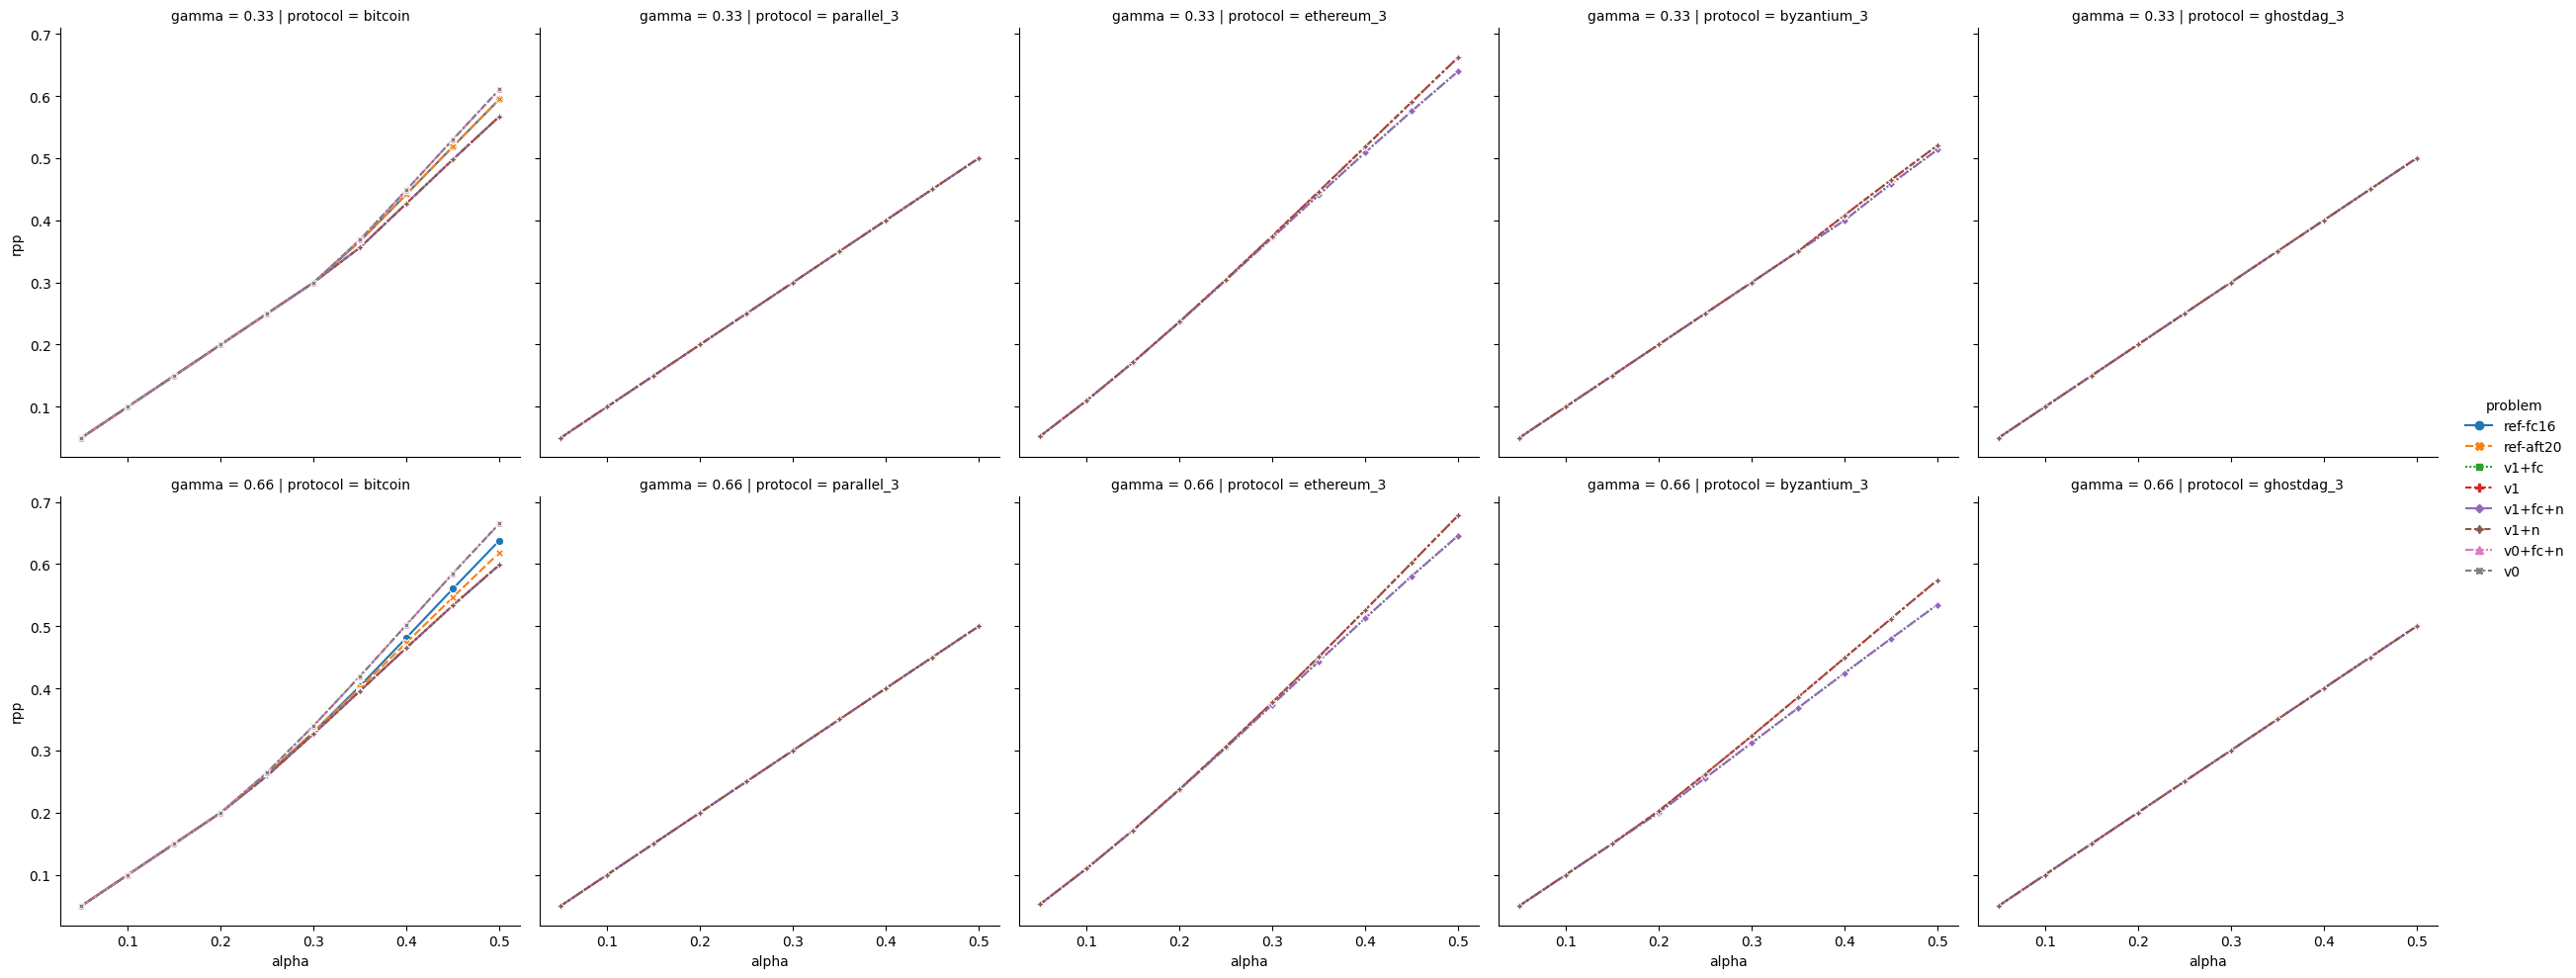

In [7]:
seaborn.relplot(
    data=df,
    kind="line",
    x="alpha",
    y="rpp",
    col="protocol",
    hue="problem",
    style="problem",
    markers=True,
    row="gamma",
)

# Revenue, PTO model, at source-model steady state

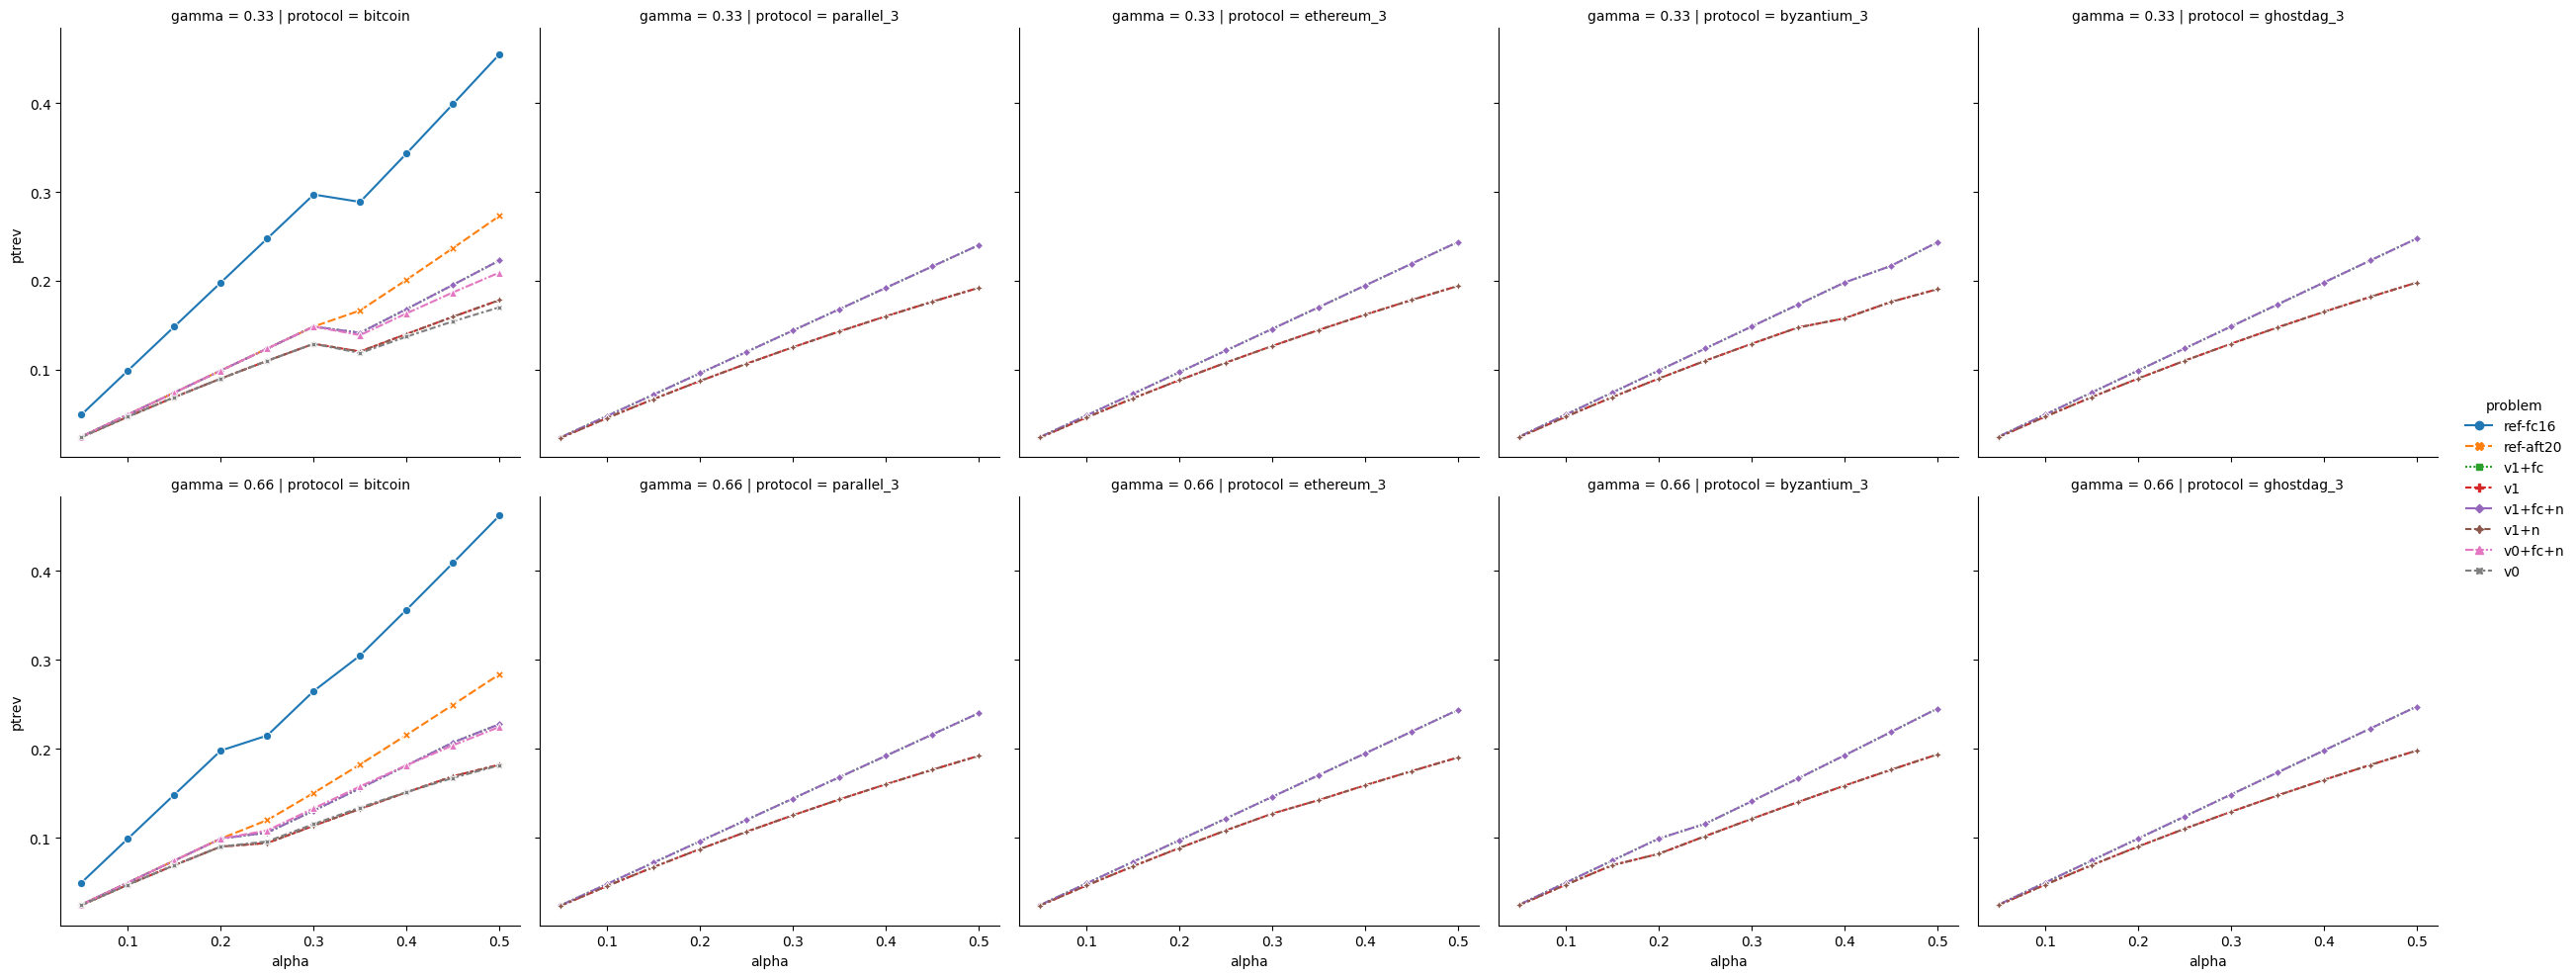

In [8]:
seaborn.relplot(
    data=df,
    kind="line",
    x="alpha",
    y="ptrev",
    col="protocol",
    hue="problem",
    style="problem",
    markers=True,
    row="gamma",
)